In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [50]:
features_detector = cv2.ORB_create(nfeatures=3000, scoreType=cv2.ORB_FAST_SCORE)

In [80]:
def computeDescriptors(image):
    keypoints, descriptors = features_detector.detectAndCompute(image,None)
    return keypoints, descriptors

def resizeWithPadding(image, newsize):
    h_offset = abs(image.shape[0] - newsize[0])
    w_offset = abs(image.shape[1] - newsize[1]) 

    result = cv2.copyMakeBorder(image,0,h_offset,0,w_offset,cv2.BORDER_CONSTANT,value=[0,0,0])
    return result

def resize(image, newsize):
    return cv2.resize(image,(newsize[1], newsize[0]), interpolation = cv2.INTER_CUBIC)

def normalizeImageSize(image, pattern_size):
    (im_w, im_h) = image.shape[1], image.shape[0]
    (pt_w, pt_h) = pattern_size[1], pattern_size[0] 
    
    coef = float(pt_h) / im_h
    print coef
    n_w = int(im_w * coef) 
    if coef < 1.0:
        return resize(image, (pt_h, n_w) )
    elif coef > 1.0:
        return resizeWithPadding(image, (pt_h, n_w) )
    return image
    


In [ ]:
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
def findMatchesBF(pattern_desc, image_desc):
    return bf_matcher.match(pattern_desc,image_desc)

In [4]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)   # or pass empty dictionary
flann_matcher = cv2.FlannBasedMatcher(index_params,search_params)

def findMatchesFlann(pattern_desc, image_desc, k = 2): #look at parametr
    return flann_matcher.knnMatch(pattern_desc,image_desc, k) 

def findGoodMatchesFlann(matches, treshold = 0.7):
    good_matches = []
    for match in matches:
        if len(match) > 1:
            m,n = match[0], match[1] 
            if m.distance < treshold*n.distance:        
                good_matches.append(m)
    return good_matches

In [39]:
def draw_matches(pattern, image, matches, kp_pattern, kp_image):
    
    result = np.hstack((pattern,image))
    
    list_kp_pattern = [kp_pattern[mat.queryIdx].pt for mat in matches] 
    list_kp_image   = [kp_image  [mat.trainIdx].pt for mat in matches]
    for qpt, tpt in zip(list_kp_pattern, list_kp_image):
        x,y = int(qpt[0]), int(qpt[1])
        cv2.line(result, (x, y), (int(tpt[0] + pattern.shape[1]), int(tpt[1])), [255, 0, 0], 1)
        
    return result

In [24]:
pattern = cv2.imread('/home/taras/Pictures/khalifa1.png')

#plt.imshow(pattern)
#plt.show()

In [81]:
image = cv2.imread('/home/taras/Pictures/khalifa3.png')
target = normalizeImageSize(image, pattern.shape )

#plt.imshow(target)
#plt.show()

1.28400954654


In [82]:
print target.shape, image.shape, pattern.shape

(538, 684, 3) (419, 533, 3) (538, 173, 3)


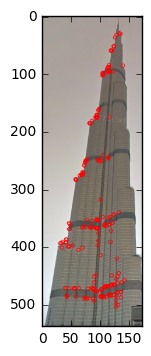

In [51]:
kp_pattern, dsc_pattern = computeDescriptors(pattern)

pattern_kps = cv2.drawKeypoints(pattern.copy(), kp_pattern, None, color=(255,0,0))
plt.imshow(pattern_kps)
plt.show()

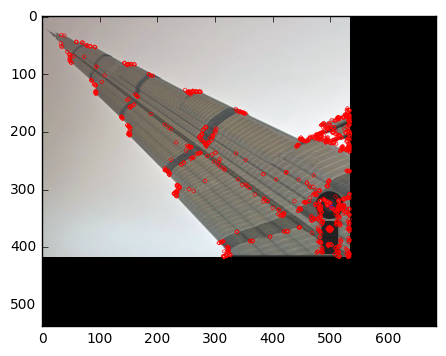

In [83]:
kp_target, dsc_target = computeDescriptors(target)

target_kps = cv2.drawKeypoints(target.copy(), kp_target, None, color=(255,0,0))
plt.imshow(target_kps)
plt.show()

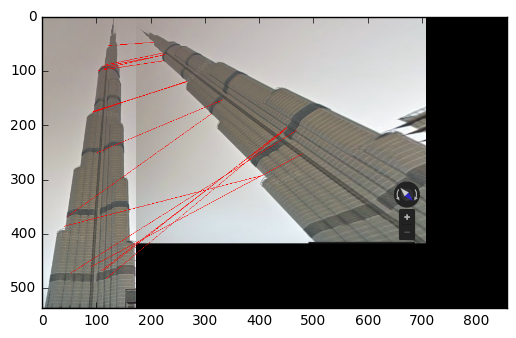

In [84]:


temp_matches = findMatchesFlann(dsc_pattern, dsc_target, 2 )
matches = findGoodMatchesFlann(temp_matches, 0.7)

result = draw_matches(pattern, target, matches, kp_pattern, kp_target)

plt.imshow(result)
plt.show()

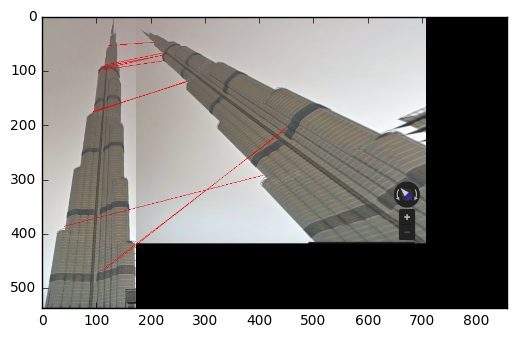

In [85]:
list_kp_pattern = np.float32([kp_pattern[mat.queryIdx].pt for mat in matches])
list_kp_image   = np.float32([kp_target [mat.trainIdx].pt for mat in matches])

M, mask = cv2.findHomography(list_kp_pattern, list_kp_image, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

result = np.hstack((pattern,target.copy()))
i = 0
for qpt, tpt in zip(list_kp_pattern, list_kp_image):
    if matchesMask[i] == 1:
        x,y = int(qpt[0]), int(qpt[1])
        cv2.line(result, (x, y), (int(tpt[0] + pattern.shape[1]), int(tpt[1])), [255, 0, 0], 1)
    i += 1
plt.imshow(result)
plt.show()

In [91]:
def draw_image(source, image, x, y):
    height = image.shape[0]
    width  = image.shape[1]    
    
    max_y = y + height   
    max_x = x + width
    
    alpha = image[:, :, 3] / 255.0
   
    for c in range(0,3):
        color = image[:, :, c] * (alpha)
        beta  = source [y:max_y, x:max_x, c] * (1.0 - alpha)
        source[y:max_y, x:max_x, c] = color + beta
    return source

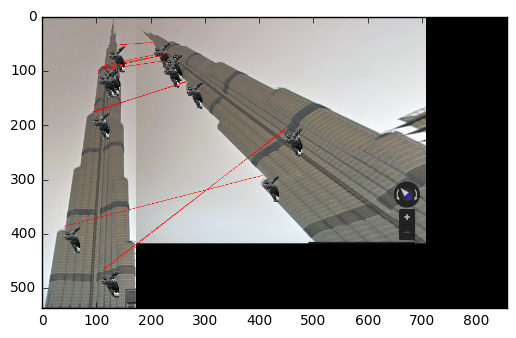

In [153]:
monkey = cv2.imread('/home/taras/Pictures/monkey.png', -1)

monkey = resize(monkey, (50, 30))

def draw_monkey(image, x, y):    
    #resized = resize(watch, (width, height))
    
    #rotated = rotate_bound(resized, angle - 90)
    draw_image(image, monkey, x, y)
    return image

point_num = 4

result = np.hstack((pattern,target))

i = 0
for qpt, tpt in zip(list_kp_pattern, list_kp_image):
    if matchesMask[i] == 1:
        x,y = int(qpt[0]), int(qpt[1])
        x2, y2 = int(tpt[0]+ pattern.shape[1]), int(tpt[1])
        result = draw_monkey(result, x, y)
        result = draw_monkey(result, x2, y2)
        cv2.line(result, (x, y), (x2, y2), [255, 0, 0], 1)
    i += 1

plt.imshow(result)
plt.show()